# **Plant Disease**

In [21]:
# importing libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator as Imgen
from keras.models import Model,Sequential
from keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Flatten,Dense,GlobalAveragePooling2D,BatchNormalization
from keras.callbacks import EarlyStopping,ModelCheckpoint

from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report

### **Data Generation**

In [22]:
traingen = Imgen(preprocessing_function=preprocess_input,
                
                shear_range = 0.2,
                zoom_range = 0.2,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                fill_mode="nearest",
                validation_split=0.15)


testgen = Imgen(preprocessing_function=preprocess_input)

In [23]:
trainds = traingen.flow_from_directory("../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                      target_size=(150,150),
                                       class_mode="categorical",
                                       seed=123,
                                       batch_size=32,
                                       subset="training"
                                      )
valds = traingen.flow_from_directory("../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                      target_size=(150,150),
                                       class_mode="categorical",
                                       seed=123,
                                       batch_size=32,
                                   subset="validation"
                                      )
testds = testgen.flow_from_directory("../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                    target_size=(150,150),
                                    class_mode="categorical",
                                    seed=123,
                                    batch_size=32,
                                    shuffle=False)

Found 59766 images belonging to 38 classes.
Found 10529 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


**Classes**

In [24]:
c = trainds.class_indices
classes = list(c.keys())
classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

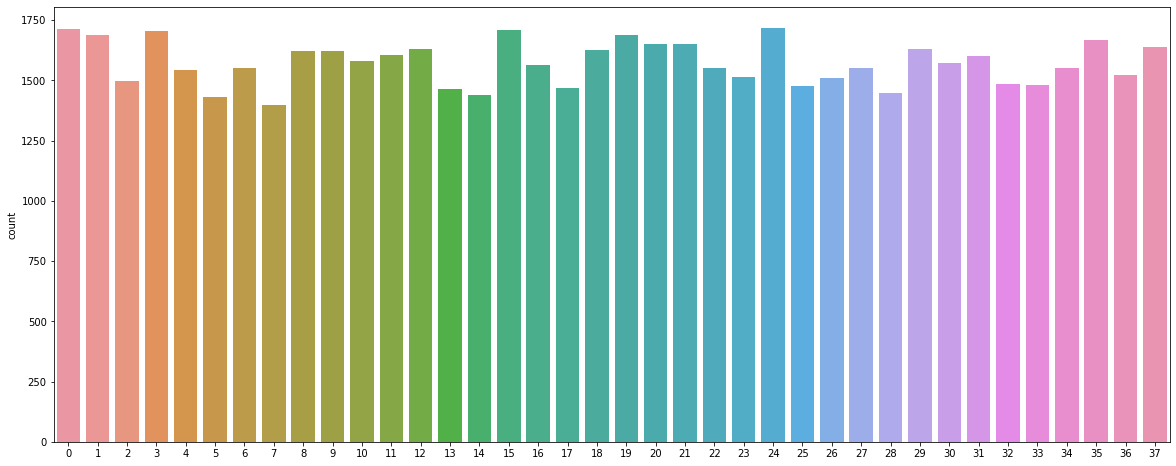

In [25]:
plt.figure(figsize=[20,8])
sns.countplot(x=trainds.classes);

**One Batch**

In [26]:
x,y = next(trainds)

# function to plot images
def plotImages(x,y):
    plt.figure(figsize=[15,11])
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(x[i])
        plt.title(classes[np.argmax(y[i])])
        plt.axis("off")
    plt.show()

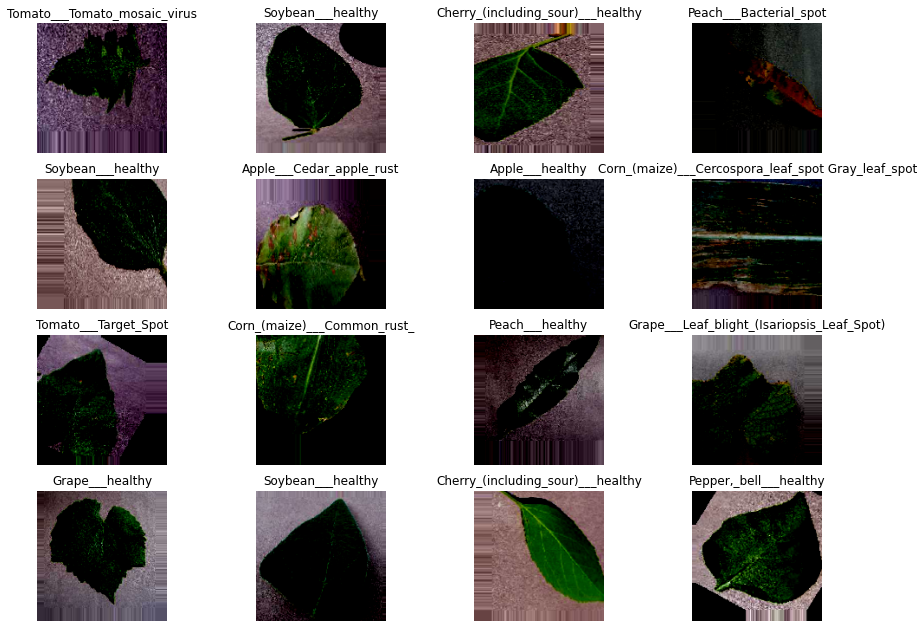

In [27]:
plotImages(x,y)

## **Model**

In [28]:
base_model = DenseNet201(include_top=False,
                     input_shape=(150,150,3),
                      weights = "imagenet",
                      pooling="avg"
                     )
base_model.trainable = False

In [29]:
image_input = Input(shape=(150,150,3))

x = base_model(image_input,training = False)

x = Dense(512,activation = "relu")(x)

x = Dropout(0.3)(x)

x = Dense(128,activation = "relu")(x)

image_output = Dense(38,activation="softmax")(x)

model = Model(image_input,image_output)

In [30]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               983552    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_5 (Dense)              (None, 38)                4902      
Total params: 19,376,102
Trainable params: 1,054,118
Non-trainable params: 18,321,984
_______________________________________

**Compile**

In [31]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

**Callbacks**

In [32]:
my_calls = [EarlyStopping(monitor="val_accuracy",patience=3),
            ModelCheckpoint("Model.h5",verbose= 1 ,save_best_only=True)]

**Train**

In [33]:
hist = model.fit(trainds,epochs=22,validation_data=valds,callbacks=my_calls)

Epoch 1/22
1868/1868 [==============================] - 506s 266ms/step - loss: 1.1385 - accuracy: 0.6655 - val_loss: 0.3392 - val_accuracy: 0.8881

Epoch 00001: val_loss improved from inf to 0.33921, saving model to Model.h5
Epoch 2/22
1868/1868 [==============================] - 507s 271ms/step - loss: 0.3918 - accuracy: 0.8712 - val_loss: 0.3004 - val_accuracy: 0.9023

Epoch 00002: val_loss improved from 0.33921 to 0.30040, saving model to Model.h5
Epoch 3/22
1868/1868 [==============================] - 485s 260ms/step - loss: 0.3363 - accuracy: 0.8913 - val_loss: 0.2528 - val_accuracy: 0.9174

Epoch 00003: val_loss improved from 0.30040 to 0.25281, saving model to Model.h5
Epoch 4/22
1868/1868 [==============================] - 485s 260ms/step - loss: 0.2996 - accuracy: 0.9019 - val_loss: 0.2575 - val_accuracy: 0.9172

Epoch 00004: val_loss did not improve from 0.25281
Epoch 5/22
1868/1868 [==============================] - 475s 254ms/step - loss: 0.2758 - accuracy: 0.9110 - val_lo

**Test**

In [34]:
model.evaluate(testds)

550/550 [==============================] - 122s 221ms/step - loss: 0.1506 - accuracy: 0.9536


[0.1505603939294815, 0.9536194205284119]

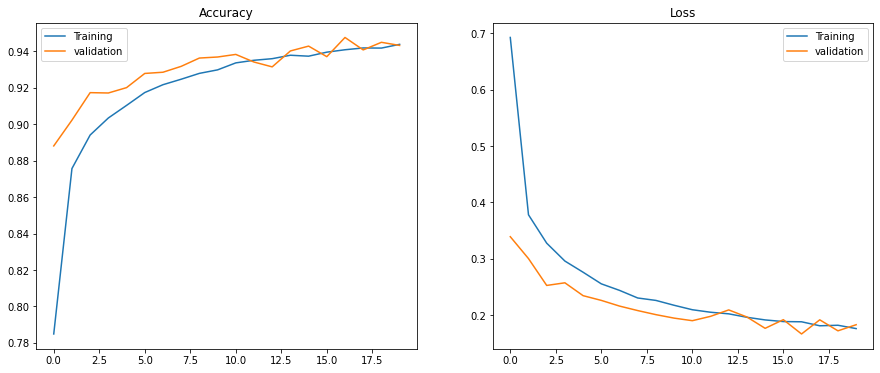

In [35]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

## **Predictions.**

In [37]:
pred = model.predict(testds)

In [38]:
pred = [np.argmax(i) for i in pred]

In [41]:
y_test = testds.classes

**Classification Report**

In [42]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       525
           1       1.00      0.96      0.98       517
           2       0.97      1.00      0.99       431
           3       0.97      0.96      0.96       506
           4       0.98      0.99      0.99       451
           5       0.95      1.00      0.97       398
           6       1.00      0.97      0.98       470
           7       0.89      0.93      0.91       392
           8       1.00      0.99      0.99       481
           9       0.94      0.91      0.92       489
          10       1.00      1.00      1.00       465
          11       0.96      0.97      0.97       468
          12       0.97      0.96      0.97       485
          13       1.00      1.00      1.00       430
          14       0.99      0.99      0.99       421
          15       0.98      1.00      0.99       494
          16       0.97      0.99      0.98       452
          17       0.99    

**Confusion Matrix**

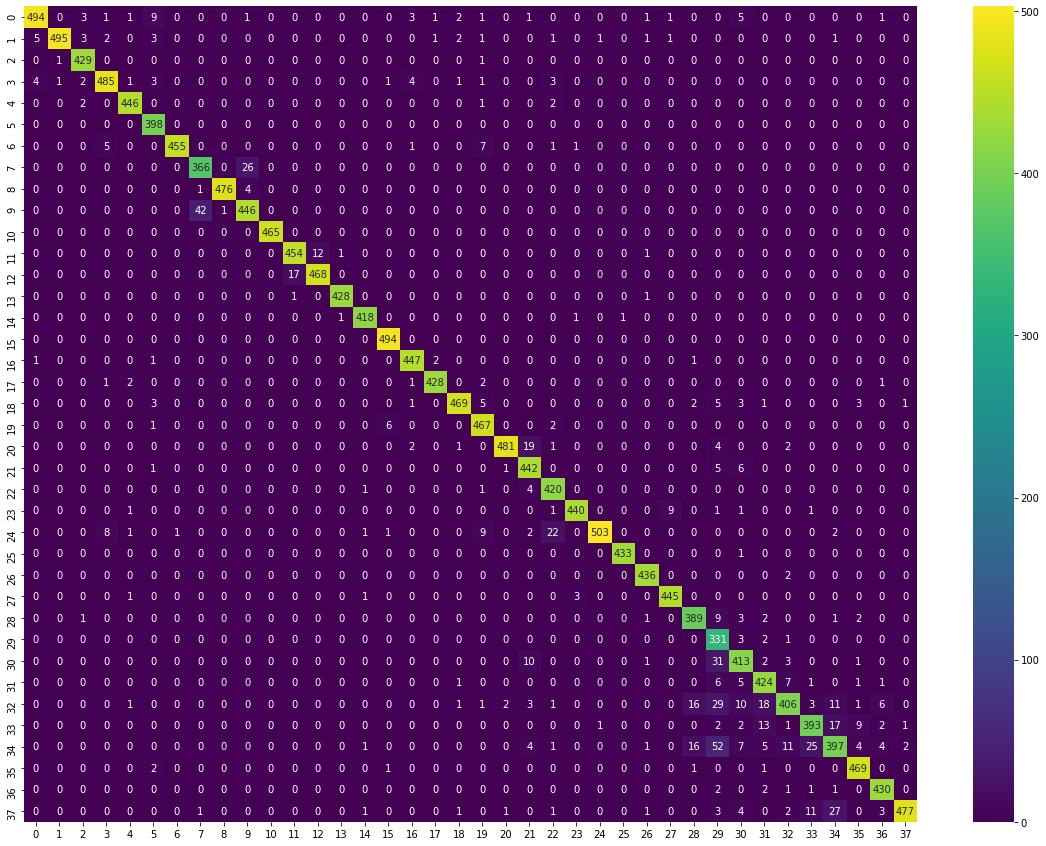

In [44]:
plt.figure(figsize=[20,15])
sns.heatmap(confusion_matrix(pred,y_test),annot = True, fmt = "d", cmap = "viridis");